<a href="https://colab.research.google.com/github/Kashara-Alvin-Ssali/Explainable-Ai-for-The-ML-Models/blob/main/ViT_Attention_Rollout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install torch torchvision transformers matplotlib opencv-python pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [4]:
# prompt: code for mounting the drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import torch

pth_path = "/content/drive/My Drive/VIT_model.pth"  # replace with your path
model_data = torch.load(pth_path, map_location='cpu')

# Check if it's a state_dict
if isinstance(model_data, dict) and all(isinstance(v, torch.Tensor) for v in model_data.values()):
    print("✅ This is a state_dict.")
else:
    print("❗ This seems like a full model object.")


✅ This is a state_dict.


In [6]:
import torch
import torchvision.transforms as transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image

In [7]:
# ======== Load model with state_dict ========
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=2, ignore_mismatched_sizes=True)
model.load_state_dict(torch.load("/content/drive/My Drive/VIT_model.pth", map_location='cpu'))
model.eval()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [8]:
# ======== Define preprocess ========
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


In [9]:
# ======== Attention rollout function ========
def compute_attention_rollout(attentions):
    # attentions shape: (layers, batch, heads, seq_len, seq_len)
    result = torch.eye(attentions[0].shape[-1])
    with torch.no_grad():
        for attention in attentions:
            # Average over heads
            attention_heads_fused = attention.mean(dim=1)[0]  # (seq_len, seq_len)
            attention_heads_fused += torch.eye(attention_heads_fused.size(0))  # add identity
            attention_heads_fused /= attention_heads_fused.sum(dim=-1, keepdim=True)
            result = torch.matmul(attention_heads_fused, result)

    # CLS token attention to all other patches
    mask = result[0, 1:]
    return mask.reshape(14, 14).cpu().numpy()


In [10]:
# ======== Visualize rollout heatmap ========
def visualize_attention_rollout(image_path, model):
    image = Image.open(image_path).convert('RGB')
    img_tensor = transform(image).unsqueeze(0)

    # Forward pass with attention output
    with torch.no_grad():
        outputs = model(pixel_values=img_tensor, output_attentions=True)
        attentions = outputs.attentions  # list of attention layers

    rollout_mask = compute_attention_rollout(attentions)

    # Resize rollout mask to image size
    rollout_mask = cv2.resize(rollout_mask, (image.size[0], image.size[1]))
    rollout_mask = (rollout_mask - rollout_mask.min()) / (rollout_mask.max() - rollout_mask.min())

    # Overlay heatmap
    img_np = np.array(image)
    plt.figure(figsize=(6, 6))
    plt.imshow(img_np)
    plt.imshow(rollout_mask, cmap='jet', alpha=0.4)
    plt.axis('off')
    plt.title("Attention Rollout Heatmap")
    plt.show()


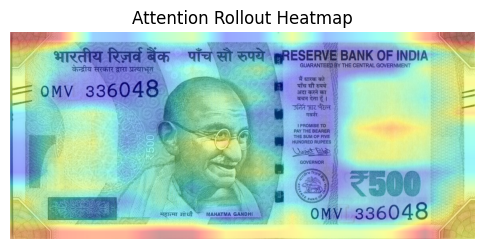

In [14]:
# ======== Example usage ========
sample_img_path = "/content/drive/MyDrive/Dataset4/Training/Fake/500_f4.jpg"  # Change this path as needed
visualize_attention_rollout(sample_img_path, model)
